# Инициализация

Загружаем библиотеки необходимые для выполнения кода ноутбука.

In [30]:
import boto3
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy
import seaborn as sns
from catboost import CatBoostClassifier, Pool
from dotenv import load_dotenv
from implicit.als import AlternatingLeastSquares
from io import BytesIO
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [2]:
sns.set_style("darkgrid")
sns.set_theme(style="darkgrid") 

In [3]:
pd.options.display.max_columns = 100
pd.options.display.max_rows = 64

In [4]:
RND_STATE = 3210

In [5]:
s3_folder_data = "recsys/data/"
s3_folder_rec = 'recsys/recommendations/'

In [6]:
def s3_load_file(local_files, s3_folder=""):
    """
    Загружает несколько локальных файлов в S3.

    Параметры:
    ----------
    local_files : list of str
        Список локальных путей к файлам.
    s3_folder : str
        Папка в S3, куда загружать файлы.
    """
    
    s3_endpoint = 'https://storage.yandexcloud.net'
    s3_region = 'ru-central1'
    bucket_name = 's3-student-mle-20241017-f11529b173'
    # получаем креды из .env
    load_dotenv()
    
    # подключение к S3
    s3_client = boto3.client(
        's3',
        aws_access_key_id=os.getenv("AWS_ACCESS_KEY_ID"),
        aws_secret_access_key=os.getenv("AWS_SECRET_ACCESS_KEY"),
        endpoint_url=s3_endpoint,
        region_name=s3_region
    )

    for local_file in local_files:
        filename = os.path.basename(local_file)
        s3_key = os.path.join(s3_folder, filename) if s3_folder else filename
        
        s3_client.upload_file(local_file, bucket_name, s3_key)
        print(f"Загружен {local_file} --> s3://{bucket_name}/{s3_key}")

In [7]:
def read_parquet_from_s3_boto3(filename, s3_folder=""):
    """
    Считывает parquet файл из S3 в pandas.DataFrame.

    Параметры:
    ----------
    filename : str
        Имя файла, который нужно загрузить.
    s3_folder : str
        Папка в S3, откуда загружать файлы.
    """

    s3_endpoint = 'https://storage.yandexcloud.net'
    s3_region = 'ru-central1'
    bucket_name = 's3-student-mle-20241017-f11529b173'
    # получаем креды из .env
    load_dotenv()

    s3_client = boto3.client(
        "s3",
        aws_access_key_id=os.getenv("AWS_ACCESS_KEY_ID"),
        aws_secret_access_key=os.getenv("AWS_SECRET_ACCESS_KEY"),
        endpoint_url=s3_endpoint,
        region_name=s3_region
    )

    buffer = BytesIO()
    s3_key = os.path.join(s3_folder, filename) if s3_folder else filename
    s3_client.download_fileobj(bucket_name, s3_key, buffer)
    buffer.seek(0)

    df = pd.read_parquet(buffer, engine="pyarrow")
    print(f"Загружен файл из S3: {s3_key}")
    return df

# === ЭТАП 1 ===

# Загрузка первичных данных

Загружаем первичные данные из файлов:
- tracks.parquet
- catalog_names.parquet
- interactions.parquet

In [6]:
tracks = pd.read_parquet("tracks.parquet")

- `track_id` — идентификатор музыкального трека;
- `albums` — список идентификаторов альбомов, содержащих трек;
- `artists` — список идентификаторов исполнителей трека;
- `genres` — список идентификаторов жанров, к которым принадлежит трек.

In [5]:
names = pd.read_parquet("catalog_names.parquet")

- `id` — идентификатор одной из каталожных единиц (трека, альбома, исполнителя, жанра);
- `type` — тип идентификатора;
- `name` — имя (название) каталожной единицы.

In [7]:
interactions = pd.read_parquet("interactions.parquet")

- `user_id` — идентификатор пользователя,
- `track_id` — идентификатор музыкального трека,
- `track_seq` — номер места трека в истории пользователя,
- `started_at` — дата начала прослушивания трека.

# Обзор данных

Проверяем данные, есть ли с ними явные проблемы.

In [5]:
names.head()

,id,type,name
0,3,album,Taller Children
1,12,album,Wild Young Hearts
2,13,album,Lonesome Crow
3,17,album,Graffiti Soul
4,26,album,Blues Six Pack


In [6]:
names.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1812471 entries, 0 to 1812470
Data columns (total 3 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   id      int64 
 1   type    object
 2   name    object
dtypes: int64(1), object(2)
memory usage: 41.5+ MB


In [7]:
names['id'].nunique()

1776697

id имеет тип int64, это избыточно, можно перевести в int32

In [8]:
interactions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 222629898 entries, 0 to 291
Data columns (total 4 columns):
 #   Column      Dtype         
---  ------      -----         
 0   user_id     int32         
 1   track_id    int32         
 2   track_seq   int16         
 3   started_at  datetime64[ns]
dtypes: datetime64[ns](1), int16(1), int32(2)
memory usage: 5.4 GB


In [9]:
interactions.shape

(222629898, 4)

В датафрейме с данными о взаимодействиях проблема с индексом - более 200 млн. записей, а индекс - только до 291.

In [10]:
interactions.index.nunique()

16637

In [11]:
interactions.index.is_unique

False

In [14]:
interactions[550:570]

,user_id,track_id,track_seq,started_at
18,9,57001313,19,2022-12-08
19,9,57003871,20,2022-12-12
20,9,57006203,21,2022-12-13
21,9,57043145,22,2022-12-15
22,9,57043816,23,2022-12-19
23,9,57175473,24,2022-12-19
24,9,57181385,25,2022-12-21
25,9,65320306,26,2022-12-25
26,9,87659100,27,2022-12-26
27,9,91007469,28,2022-12-28


Похоже индекс дублирует track_seq, только начинается с 0, а не с 1. Сбрасываю индекс.

In [15]:
interactions = interactions.reset_index(drop=True)

In [16]:
interactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 222629898 entries, 0 to 222629897
Data columns (total 4 columns):
 #   Column      Dtype         
---  ------      -----         
 0   user_id     int32         
 1   track_id    int32         
 2   track_seq   int16         
 3   started_at  datetime64[ns]
dtypes: datetime64[ns](1), int16(1), int32(2)
memory usage: 3.7 GB


user_id и track_id в interactions имеют тип int32

In [17]:
tracks.head()

,track_id,albums,artists,genres
0,26,"[3, 2490753]",[16],"[11, 21]"
1,38,"[3, 2490753]",[16],"[11, 21]"
2,135,"[12, 214, 2490809]",[84],[11]
3,136,"[12, 214, 2490809]",[84],[11]
4,138,"[12, 214, 322, 72275, 72292, 91199, 213505, 24...",[84],[11]


In [18]:
tracks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 4 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   track_id  1000000 non-null  int64 
 1   albums    1000000 non-null  object
 2   artists   1000000 non-null  object
 3   genres    1000000 non-null  object
dtypes: int64(1), object(3)
memory usage: 30.5+ MB


track_id в tracks имеет тип int64, что скорее всего избыточно. albums, artists и genres представлены как списки чисел, поэтому имеют тип object.

In [19]:
tracks['track_id'].nunique()

1000000

Возможно некоторые списки пустые. Проверим это

In [20]:
# Количество строк без альбомов (albums = [])
empty_albums = (tracks['albums'].str.len() == 0).sum()
print("Строк без альбомов:", empty_albums)

# Количество строк без исполнителей (artists = [])
empty_artists = (tracks['artists'].str.len() == 0).sum()
print("Строк без исполнителей:", empty_artists)

# Количество строк без жанров (genres = [])
empty_genres = (tracks['genres'].str.len() == 0).sum()
print("Строк без жанров:", empty_genres)

Строк без альбомов: 18
Строк без исполнителей: 15369
Строк без жанров: 3687


In [21]:
has_empty = (
    (tracks['albums'].str.len() == 0) |
    (tracks['artists'].str.len() == 0) |
    (tracks['genres'].str.len() == 0)
)

total_empty = has_empty.sum()
print("Всего строк с хотя бы одним пустым списком:", total_empty)

Всего строк с хотя бы одним пустым списком: 19023


In [22]:
all_empty = (
    (tracks['albums'].str.len() == 0) &
    (tracks['artists'].str.len() == 0) &
    (tracks['genres'].str.len() == 0)
)

total_all_empty = all_empty.sum()
print("Всего строк со всеми пустыми списками:", total_all_empty)

Всего строк со всеми пустыми списками: 18


Проверяю, встречаются ли треки с пропусками в датафрейме со взаимодействиями

In [23]:
tracks_with_missing_data = tracks.loc[has_empty, 'track_id'].unique()

In [24]:
missing_tracks_in_interactions = interactions[
    interactions['track_id'].isin(tracks_with_missing_data)
]

if not missing_tracks_in_interactions.empty:
    print("⚠️ Взаимодействия с треками, у которых есть пропуски в tracks:")
    print(f"Количество таких взаимодействий: {len(missing_tracks_in_interactions)}")
    print(f"Доля таких взаимодействий: {len(missing_tracks_in_interactions) / interactions.shape[0]:.1%}")
    print("Примеры track_id:", missing_tracks_in_interactions['track_id'].unique()[:5])
else:
    print("✅ В interactions нет взаимодействий с треками, у которых пропуски в tracks.")

⚠️ Взаимодействия с треками, у которых есть пропуски в tracks:
Количество таких взаимодействий: 445449
Доля таких взаимодействий: 0.2%
Примеры track_id: [47273871  1527076 20969110 24572678 39831568]


In [25]:
print(f"Доля строк в tracks с хотя бы одним пустым списком: {total_empty / tracks.shape[0]:.1%}")

Доля строк в tracks с хотя бы одним пустым списком: 1.9%


Заменяю пропуски на специальные значения (-1)

In [7]:
UNKNOWN_ID = -1

tracks["genres"] = tracks["genres"].apply(lambda x: x if len(x) > 0 else [UNKNOWN_ID])
tracks["artists"] = tracks["artists"].apply(lambda x: x if len(x) > 0 else [UNKNOWN_ID])
tracks["albums"] = tracks["albums"].apply(lambda x: x if len(x) > 0 else [UNKNOWN_ID])

Привожу к типу int32 идентификаторы в names и tracks

In [8]:
names["id"] = names["id"].astype("int32")
tracks["track_id"] = tracks["track_id"].astype("int32")

# Выводы

Приведём выводы по первому знакомству с данными:
- есть ли с данными явные проблемы,
- какие корректирующие действия (в целом) были предприняты.

В данных обнаружены следующие проблемы:
- тип идентификаторов в датафреймах `names` и `tracks` - `int64`, что является избыточным и не совпадает с типом идентификаторов в датафрейме `interactions`;
- индекс в датафрейме `interactions` не является уникальным;
- в датафрейме tracks есть записи с пустыми списками в полях `albums`, `artists` и `genres`.

Что было сделано:
- тип идентификаторов изменён на `int32`;
- сброшен индекс в `interactions`;
- пустые записи заменены на `-1`

# === ЭТАП 2 ===

# EDA

## Распределение количества прослушанных треков.

In [54]:
user_track_counts = interactions.groupby("user_id")["track_id"].count().reset_index()

In [55]:
user_track_counts['track_id'].describe().round(2)

count    1373221.00
mean         162.12
std          351.28
min            1.00
25%           23.00
50%           55.00
75%          154.00
max        16637.00
Name: track_id, dtype: float64

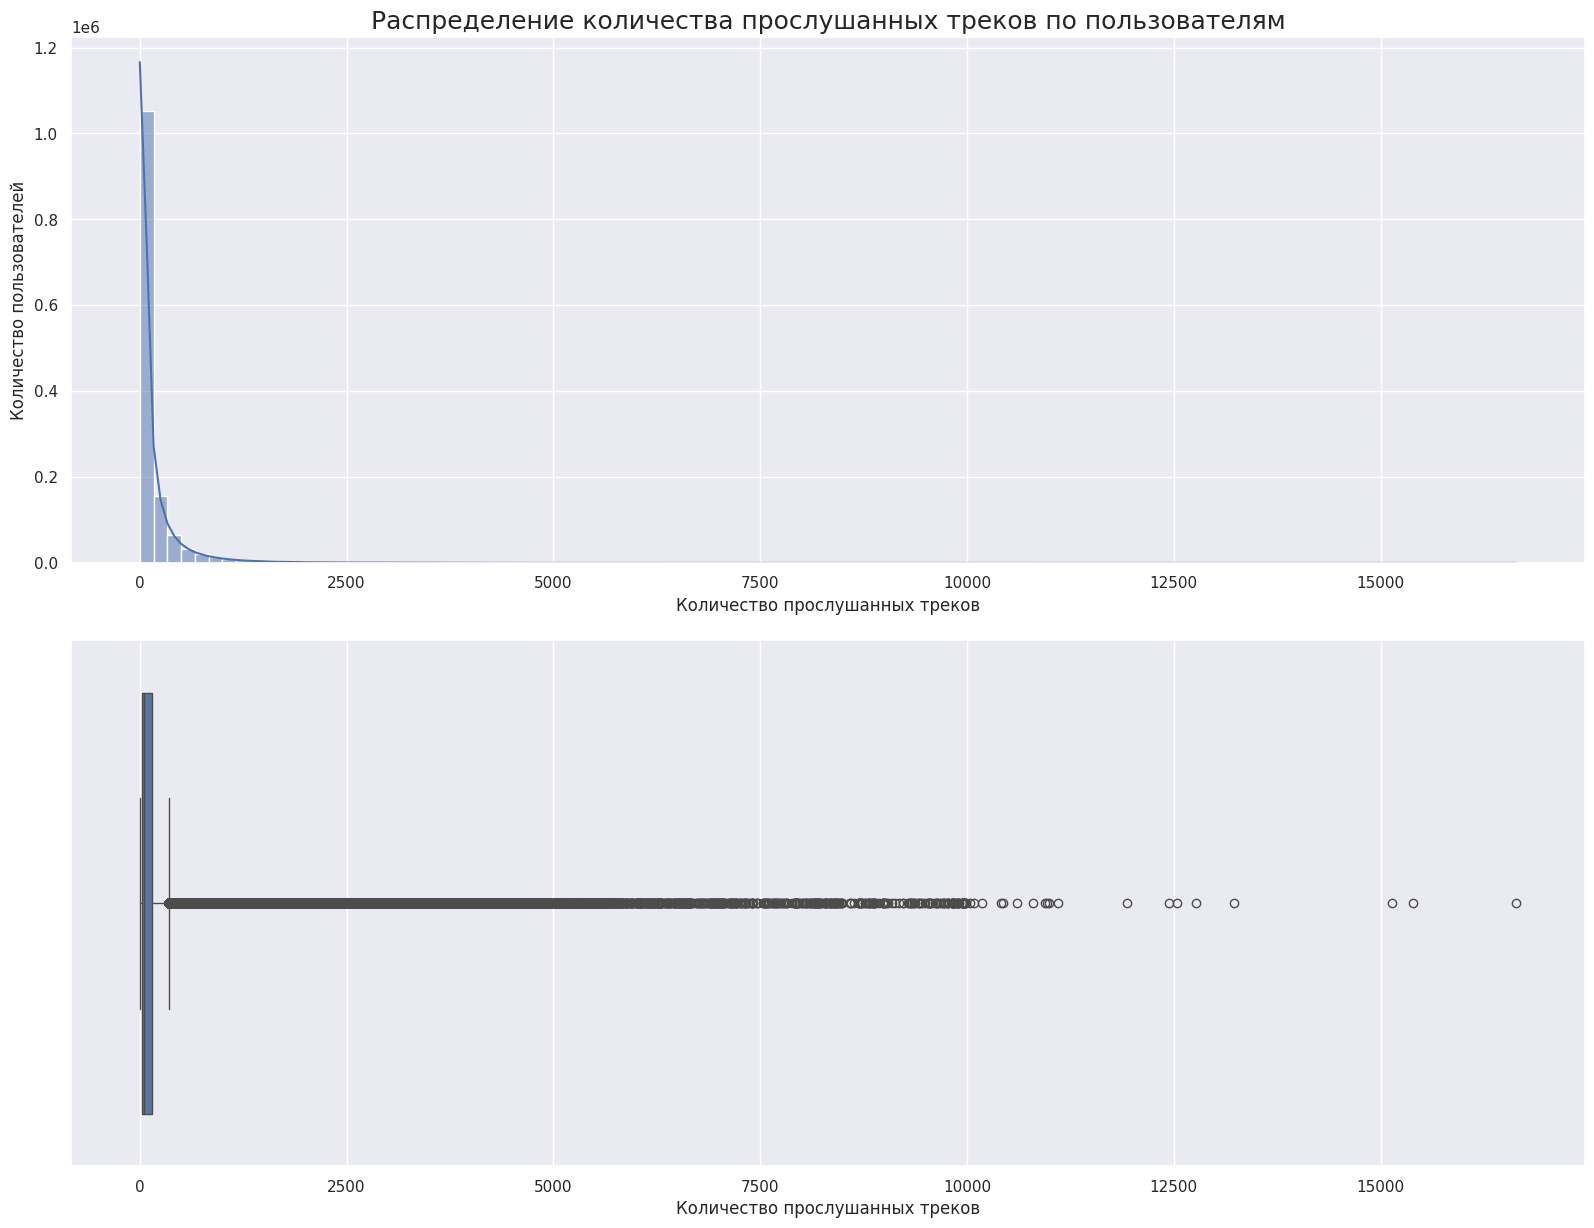

In [61]:
fig, axs = plt.subplots(2, 1) 
fig.set_size_inches(16.5, 12.5, forward=True)
fig.tight_layout(pad=2.6)

x = "track_id"
x_label = "Количество прослушанных треков"
sns.histplot(user_track_counts, x=x, kde=True, bins=100, ax=axs[0])
axs[0].set_title(f'Распределение количества прослушанных треков по пользователям', fontsize=18)
axs[0].set_xlabel(x_label)
axs[0].set_ylabel("Количество пользователей")

sns.boxplot(user_track_counts, x=x, ax=axs[1])
axs[1].set_xlabel(x_label)

plt.show()

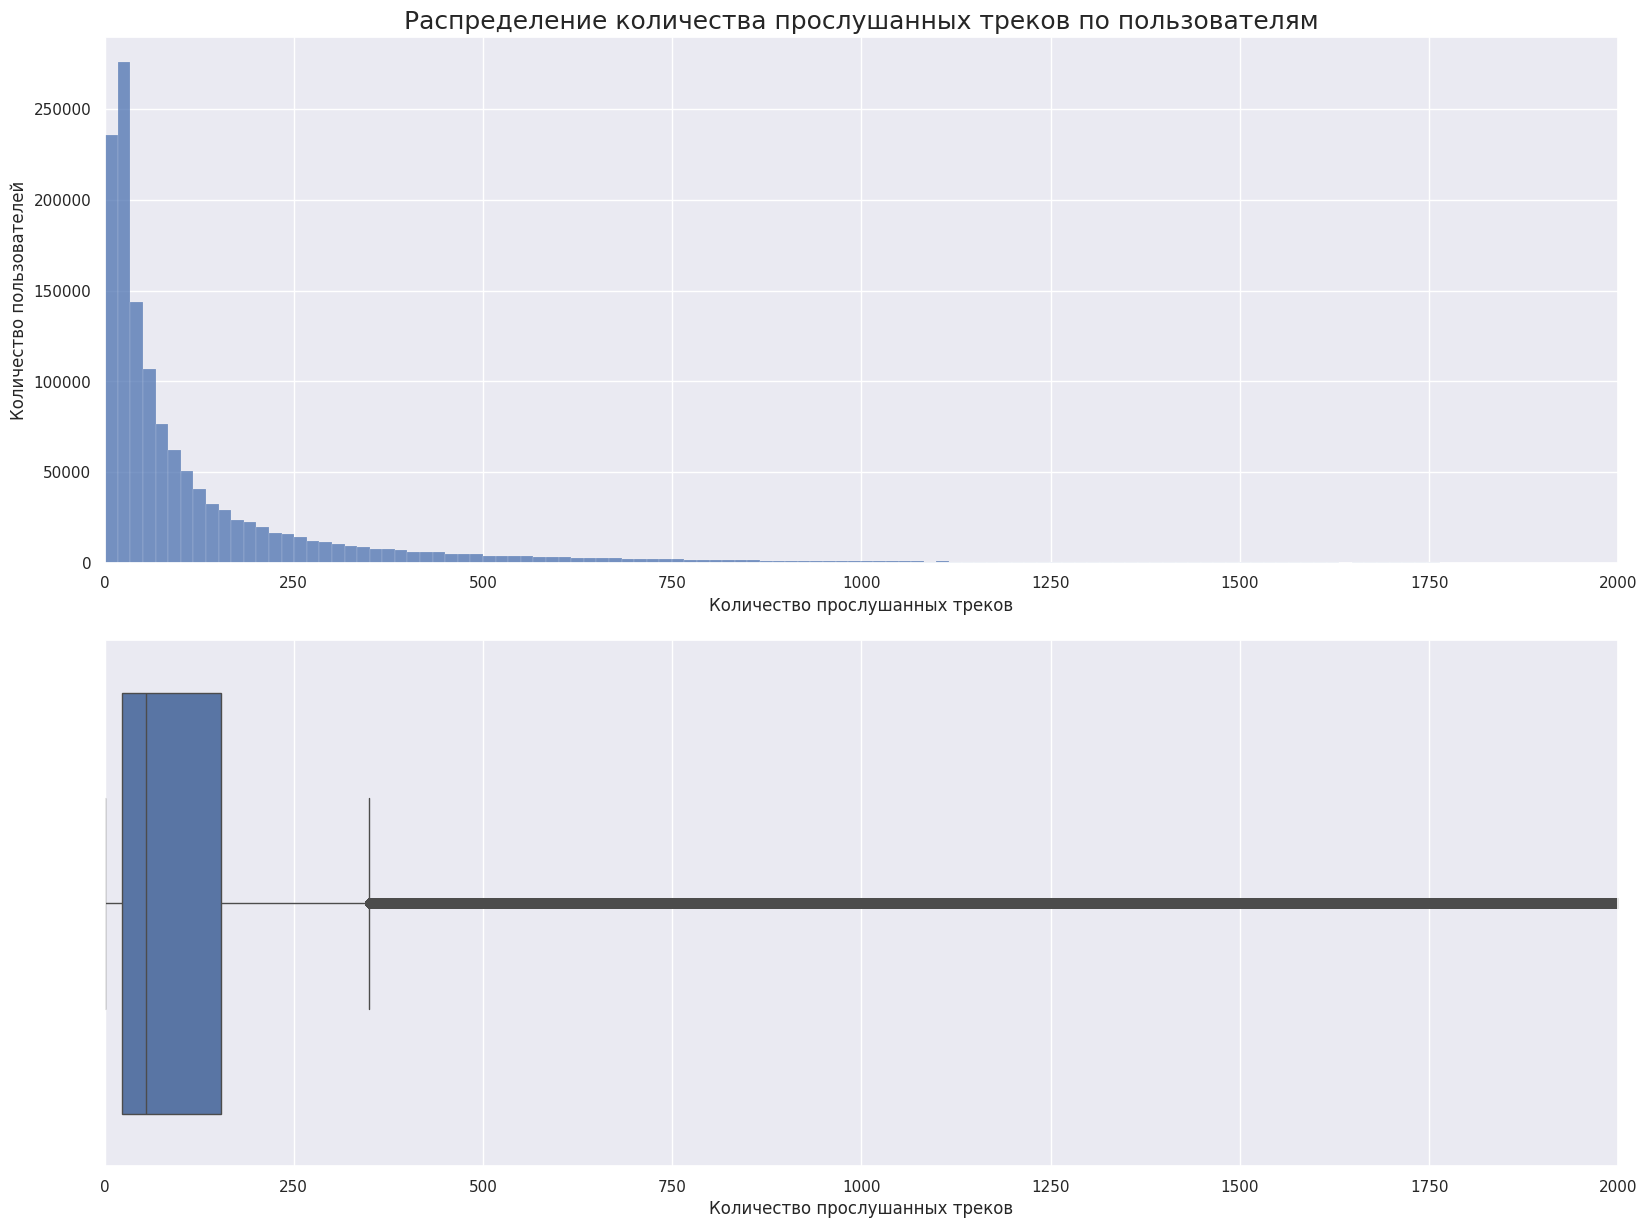

In [64]:
fig, axs = plt.subplots(2, 1) 
fig.set_size_inches(16.5, 12.5, forward=True)
fig.tight_layout(pad=2.6)

x = "track_id"
x_label = "Количество прослушанных треков"
sns.histplot(user_track_counts, x=x, bins=1000, ax=axs[0])
axs[0].set_title(f'Распределение количества прослушанных треков по пользователям', fontsize=18)
axs[0].set_xlabel(x_label)
axs[0].set_ylabel("Количество пользователей")
axs[0].set_xlim(0, 2000)

sns.boxplot(user_track_counts, x=x, ax=axs[1])
axs[1].set_xlabel(x_label)
axs[1].set_xlim(0, 2000)

plt.show()

Большинство пользователей прослушали несколько десятков треков. Тех, кто прослушал более 300, совсем мало.

## Наиболее популярные треки

In [77]:
# топ-20 треков по прослушиваниям
popular_tracks = interactions["track_id"].value_counts().head(20).rename_axis("track_id").reset_index(name="count")

# получаем genres, albums, artists из таблицы tracks
popular_tracks_info = popular_tracks.merge(tracks, on="track_id", how="left")

# получаем названия треков
track_names = names[names["type"] == "track"][["id", "name"]].rename(columns={"id": "track_id", "name": "track_name"})
popular_tracks_info = popular_tracks_info.merge(track_names, on="track_id", how="left")

# словари для жанров, альбомов, исполнителей
genres_dict = names[names["type"] == "genre"][["id", "name"]].rename(columns={"id": "genre_id", "name": "genre_name"})
albums_dict = names[names["type"] == "album"][["id", "name"]].rename(columns={"id": "album_id", "name": "album_name"})
artists_dict = names[names["type"] == "artist"][["id", "name"]].rename(columns={"id": "artist_id", "name": "artist_name"})

# разворачиваем списки genres
genres_exploded = popular_tracks_info[["track_id", "genres"]].explode("genres")
genres_exploded = genres_exploded.merge(genres_dict, left_on="genres", right_on="genre_id", how="left")
genres_agg = genres_exploded.groupby("track_id")["genre_name"].apply(lambda x: ", ".join(x.dropna().unique()))

# разворачиваем списки albums
albums_exploded = popular_tracks_info[["track_id", "albums"]].explode("albums")
albums_exploded = albums_exploded.merge(albums_dict, left_on="albums", right_on="album_id", how="left")
albums_agg = albums_exploded.groupby("track_id")["album_name"].apply(lambda x: ", ".join(x.dropna().unique()))

# разворачиваем списки artists
artists_exploded = popular_tracks_info[["track_id", "artists"]].explode("artists")
artists_exploded = artists_exploded.merge(artists_dict, left_on="artists", right_on="artist_id", how="left")
artists_agg = artists_exploded.groupby("track_id")["artist_name"].apply(lambda x: ", ".join(x.dropna().unique()))

# финальная таблица
popular_tracks_final = popular_tracks_info[["track_id", "count", "track_name"]].set_index("track_id")
popular_tracks_final = popular_tracks_final.join(albums_agg).join(genres_agg).join(artists_agg)

popular_tracks_final = popular_tracks_final.rename(columns={
    "album_name": "albums",
    "genre_name": "genres",
    "artist_name": "artists"
}).reset_index()

Самые популярные 20 треков:

In [78]:
popular_tracks_final

,track_id,count,track_name,albums,genres,artists
0,53404,111062,Smells Like Teen Spirit,"Nevermind, Nirvana, Skiing Music, Smells Like ...","alternative, rock, allrock",Nirvana
1,33311009,106921,Believer,"Shape Of Pop, NOW That's What I Call Music, Ev...","rock, allrock",Imagine Dragons
2,178529,101924,Numb,"Meteora, 00s Rock Anthems","numetal, metal",Linkin Park
3,35505245,99490,I Got Love,I Got Love,"rusrap, rap","Miyagi & Эндшпиль, Рем Дигга"
4,65851540,86670,Юность,Юность,"pop, ruspop",Dabro
5,24692821,86246,Way Down We Go,"Way down We Go, Summer Music 2016, A/B, DFM Da...",indie,KALEO
6,32947997,85886,Shape of You,"Shape of You, ÷, Summer Vibes, Pop",pop,Ed Sheeran
7,51241318,85244,In The End,"In the End, Christian TikTok, Trending Now 202...",rnb,"Tommee Profitt, Fleurie, Mellen Gi"
8,795836,85042,Shape Of My Heart,"Ten Summoner's Tales, 25 Years, The Best Of 25...","pop, rock, allrock",Sting
9,45499814,84748,Life,"Life, Made in Russia, Fresh Dance, Учителя (Му...","pop, ruspop",Zivert


## Наиболее популярные жанры

In [ ]:
# количество прослушиваний по каждому треку
track_play_counts = interactions["track_id"].value_counts().rename_axis("track_id").reset_index(name="play_count")

# жанры треков
tracks_genres = tracks[["track_id", "genres"]].copy()
tracks_genres["genres"] = tracks_genres["genres"].apply(lambda x: x if len(x) > 0 else [-1])  # unknown genre -1
tracks_genres_exploded = tracks_genres.explode("genres")

# добавляем play_count к жанрам
tracks_genres_counts = tracks_genres_exploded.merge(track_play_counts, on="track_id", how="left")

# популярность жанров
genre_popularity = tracks_genres_counts.groupby("genres")["play_count"].sum().sort_values(ascending=False).head(10)

# названия жанров
genre_names = names[names["type"]=="genre"][["id", "name"]]

popular_genres_named = genre_popularity.rename_axis("genre_id").reset_index(name="count")
popular_genres_named = popular_genres_named.merge(genre_names, left_on="genre_id", right_on="id", how="left")

In [10]:
popular_genres_named

,genre_id,count,id,name
0,11,55578312,11,pop
1,75,37799821,75,rap
2,102,31092013,102,allrock
3,20,26626241,20,ruspop
4,3,25303695,3,rusrap
5,68,20120981,68,electronics
6,16,16291557,16,dance
7,2,13166147,2,rusrock
8,14,12772644,14,rock
9,47,12437375,47,metal


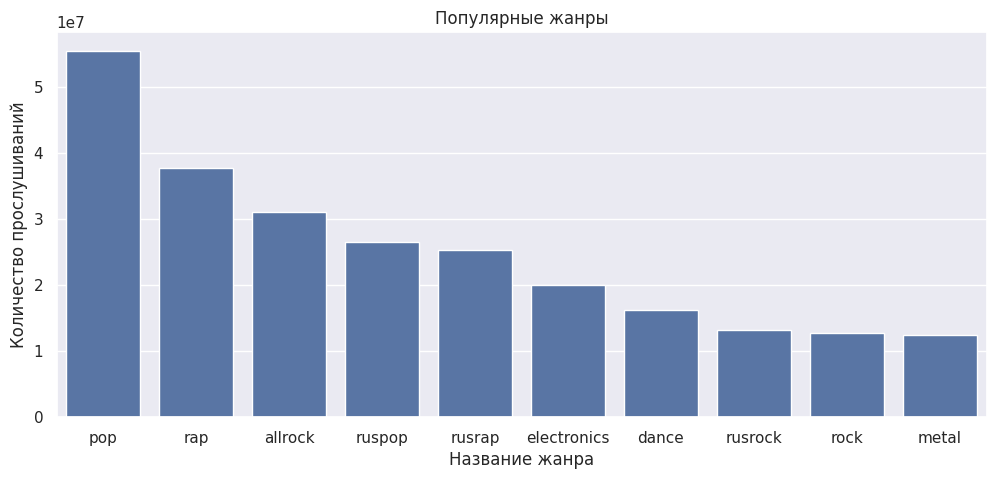

In [13]:
plt.figure(figsize=(12,5))
sns.barplot(popular_genres_named, x='name', y='count')
plt.xlabel("Название жанра")
plt.ylabel("Количество прослушиваний")
plt.title("Популярные жанры")
plt.show()

Самая популярная со значительным отрывом - поп-музыка, затем рэп и allrock

## Треки, которые никто не прослушал

In [9]:
all_tracks = set(tracks["track_id"])
interacted_tracks = set(interactions["track_id"])

unlistened_tracks = all_tracks - interacted_tracks

print(f"Количество треков, которые никто не прослушал: {len(unlistened_tracks)}")

Количество треков, которые никто не прослушал: 0


Среди треков нет таких, которые никто ни разу не прослушал.

## Выводы по EDA

- в медианном значении по данным прослушанных треков на пользователя приходится около 50 треков. Есть неактивные пользователи, которые прослушали единицы треков.
- получен топ популярных треков и топ популярных жанров. Несмотря на то, что самый популярный жанр - это поп-музыка, в топ популярных треков попало довольно много рока, причём на верхние позиции
- в данных по трекам нет таких композиций, которых никто не прослушал.

# Преобразование данных

Преобразуем данные в формат, более пригодный для дальнейшего использования в расчётах рекомендаций.

*Все преобразования сделаны на 1 этапе*

# Сохранение данных

Сохраним данные в двух файлах в персональном S3-бакете по пути `recsys/data/`:
- `items.parquet` — все данные о музыкальных треках,
- `events.parquet` — все данные о взаимодействиях.

In [19]:
tracks.to_parquet("items.parquet")
interactions.to_parquet("events.parquet")

In [ ]:
s3_load_file(["items.parquet", "events.parquet"], s3_folder=s3_folder_data)

Загружен items.parquet --> s3://s3-student-mle-20241017-f11529b173/recsys/data/items.parquet
Загружен events.parquet --> s3://s3-student-mle-20241017-f11529b173/recsys/data/events.parquet


# Очистка памяти

Здесь, может понадобится очистка памяти для высвобождения ресурсов для выполнения кода ниже. 

Приведите соответствующие код, комментарии, например:
- код для удаление более ненужных переменных,
- комментарий, что следует перезапустить kernel, выполнить такие-то начальные секции и продолжить с этапа 3.

In [8]:
# Удаляем ненужные переменные
del tracks
del interactions
# del names

Можно перезапустить kernel, выполнить ячейки из раздела "Инициализация" и продолжить с этапа 3

# === ЭТАП 3 ===

# Загрузка данных

Если необходимо, то загружаем items.parquet, events.parquet.

In [7]:
items = read_parquet_from_s3_boto3("items.parquet", s3_folder_data)

Загружен файл из S3: recsys/data/items.parquet


In [8]:
events = read_parquet_from_s3_boto3("events.parquet", s3_folder_data)

Загружен файл из S3: recsys/data/events.parquet


# Разбиение данных

Разбиваем данные на тренировочную, тестовую выборки.

In [11]:
events['started_at'].describe()

count                        222629898
mean     2022-08-29 16:39:44.541336320
min                2022-01-01 00:00:00
25%                2022-07-02 00:00:00
50%                2022-09-15 00:00:00
75%                2022-11-09 00:00:00
max                2022-12-31 00:00:00
Name: started_at, dtype: object

Представлены взаимодействия за весь 2022 год

In [11]:
# задаем точку разбиения
train_test_global_time_split_date = pd.to_datetime("2022-12-16")
train_test_global_time_split_idx = events["started_at"] < train_test_global_time_split_date

events_train = events[train_test_global_time_split_idx]
events_test = events[~train_test_global_time_split_idx]

In [12]:
print('Количество записей')
print(f'events - {events.shape[0]:,}')
print(f'events_train - {events_train.shape[0]:,}')
print(f'events_test - {events_test.shape[0]:,}')

Количество записей
events - 222,629,898
events_train - 208,731,252
events_test - 13,898,646


In [16]:
# количество пользователей в train и test
users_train = events_train["user_id"].drop_duplicates()
users_test = events_test["user_id"].drop_duplicates()
# количество пользователей, которые есть и в train, и в test
common_users = set(users_train) & set(users_test)
# количество холодных пользователей
cold_users = set(users_test) - set(users_train)

In [17]:
print(f'Пользователей в train: {len(users_train):,}')
print(f'Пользователей в test: {len(users_test):,}')
print(f'Общих пользователей: {len(common_users):,}')
print(f'Холодных пользователей: {len(cold_users):,}')

Пользователей в train: 1,342,566
Пользователей в test: 783,525
Общих пользователей: 752,870
Холодных пользователей: 30,655


При таком количестве пользователей и записей не удаётся завершить получение рекомендаций от ALS модели с текущей конфигурацией виртуальной машины. Поэтому уменьшаю количество записей - беру данные после 01.06.2022 и оставляю для обучения модели топ самых активных пользователей (200 000)

In [9]:
train_reduce_date = pd.to_datetime('2022-06-01')
events_reduced = events[events['started_at'] >= train_reduce_date].reset_index(drop=True)

In [12]:
events_reduced.head()

,user_id,track_id,track_seq,started_at
0,0,99262,1,2022-07-17
1,0,589498,2,2022-07-19
2,0,590262,3,2022-07-21
3,0,590303,4,2022-07-22
4,0,590692,5,2022-07-22


In [10]:
# задаем точку разбиения
train_test_global_time_split_date = pd.to_datetime("2022-12-16")
train_test_global_time_split_idx = events_reduced["started_at"] < train_test_global_time_split_date

events_train = events_reduced[train_test_global_time_split_idx]
events_test = events_reduced[~train_test_global_time_split_idx]

In [11]:
n_top_users = 200_000
user_activity = events_train['user_id'].value_counts()
top_users = user_activity.head(n_top_users).index
events_train_reduced = events_train[events_train['user_id'].isin(top_users)]

In [12]:
print('Количество записей')
print(f'events_train_reduced - {events_train_reduced.shape[0]:,}')
print(f'events_test - {events_test.shape[0]:,}')

Количество записей
events_train_reduced - 110,300,809
events_test - 13,898,646


In [17]:
# количество пользователей в train и test
users_train_reduced = events_train_reduced["user_id"].drop_duplicates()
users_test = events_test["user_id"].drop_duplicates()
# количество пользователей, которые есть и в train, и в test
common_users = set(users_train_reduced) & set(users_test)
# количество холодных пользователей
cold_users = set(users_test) - set(users_train_reduced)
print(f'Пользователей в train_reduced: {len(users_train_reduced):,}')
print(f'Пользователей в test: {len(users_test):,}')
print(f'Общих пользователей: {len(common_users):,}')
print(f'Холодных пользователей: {len(cold_users):,}')

Пользователей в train_reduced: 200,000
Пользователей в test: 783,525
Общих пользователей: 124,724
Холодных пользователей: 658,801


Сохраняю `events_train_reduced` и `events_test` для последующего использования, чтобы не повторять обработку

In [13]:
events_train_reduced.to_parquet("events_train_reduced.parquet")
events_test.to_parquet("events_test.parquet")
s3_load_file(["events_train_reduced.parquet", "events_test.parquet"], s3_folder=s3_folder_data)

Загружен events_train_reduced.parquet --> s3://s3-student-mle-20241017-f11529b173/recsys/data/events_train_reduced.parquet
Загружен events_test.parquet --> s3://s3-student-mle-20241017-f11529b173/recsys/data/events_test.parquet


# Топ популярных

Рассчитаем рекомендации как топ популярных.

In [18]:
top_tracks = (
    events_train_reduced.groupby("track_id")["user_id"]
    .count()
    .sort_values(ascending=False)
    .reset_index()
    .rename(columns={"user_id": "play_count"})
)

In [19]:
top_100_items = pd.DataFrame(top_tracks["track_id"].head(100))

In [20]:
top_100_items.to_parquet("top_100_items.parquet")

In [21]:
s3_load_file(["top_100_items.parquet"], s3_folder=s3_folder_rec)

Загружен top_100_items.parquet --> s3://s3-student-mle-20241017-f11529b173/recsys/recommendations/top_100_items.parquet


# Персональные

Рассчитаем персональные рекомендации.

In [ ]:
user_ids = events_train_reduced['user_id'].unique()
track_ids = events_train_reduced['track_id'].unique()

user_to_idx = {user_id: idx for idx, user_id in enumerate(user_ids)}
track_to_idx = {track_id: idx for idx, track_id in enumerate(track_ids)}
idx_to_track = {idx: track_id for track_id, idx in track_to_idx.items()}

# Создаём CSR матрицу из обучающих данных
rows = events_train_reduced['user_id'].map(user_to_idx).values
cols = events_train_reduced['track_id'].map(track_to_idx).values

user_item_matrix_train = scipy.sparse.csr_matrix(
    (np.ones(len(rows)), (rows, cols)),
    shape=(len(user_ids), len(track_ids))
)

Создаю и обучаю ALS-модель

In [27]:
als_model = AlternatingLeastSquares(
    factors=50,
    iterations=30,
    regularization=0.05,
    random_state=RND_STATE
)
als_model.fit(user_item_matrix_train)

/home/mle-user/mle_projects/mle-project-sprint-4-v001/venv_project_04/lib/python3.10/site-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 4 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()


  0%|          | 0/30 [00:00<?, ?it/s]

Получаю персональные рекомендации, по 20 треков на пользователя, т.к. получение рекомендаций занимает много времени и может быть прервано тайм-аутом виртуальной машины

In [28]:
rec_personal = []
    
for user_id, user_idx in tqdm(user_to_idx.items(), desc="Generating recommendations"):
    # Рекомендуем треки, которые пользователь ещё не слушал в train
    ids, scores = als_model.recommend(
        user_idx,
        user_item_matrix_train[user_idx],
        N=20,
        filter_already_liked_items=True
    )
    
    track_ids = [idx_to_track[idx] for idx in ids]

    for track_id, score in zip(track_ids, scores):
            rec_personal.append({
                'user_id': user_id,
                'track_id': track_id,
                'score': score
            })

personal_als_df = pd.DataFrame(rec_personal)
personal_als_df.to_parquet("personal_als.parquet", index=False)
s3_load_file(["personal_als.parquet"], s3_folder=s3_folder_rec)

Generating recommendations: 100%|████████████████████████████████████████████████████████████████████████████| 200000/200000 [45:27<00:00, 73.32it/s]


Загружен personal_als.parquet --> s3://s3-student-mle-20241017-f11529b173/recsys/recommendations/personal_als.parquet


# Похожие

Рассчитаем похожие, они позже пригодятся для онлайн-рекомендаций.

Для расчёта похожих треков беру те, которые есть и в test, и в train. Если брать все треки, которые есть в train, не хватает мощности ВМ, чтобы завершить обработку до тайм-аута 

In [19]:
print('Количество уникальных треков в train:', events_train_reduced['track_id'].nunique())
test_track_ids = events_test['track_id'].unique()
print('Количество уникальных треков в test:', len(test_track_ids))

# оставляю только те, которые есть в ALS обучении (events_train) и в test
valid_test_track_ids = [tid for tid in test_track_ids if tid in track_to_idx]
print('Количество общих треков train и test:', len(valid_test_track_ids))

Количество уникальных треков в train: 987880
Количество уникальных треков в test: 594326
Количество общих треков train и test: 588872


In [21]:
similar_items = []
k=10
    
for track_id in tqdm(valid_test_track_ids, desc="Generating similar items"):
    
    track_idx = track_to_idx[track_id]
    
    # Получаем похожие треки напрямую из ALS модели
    similar_idx, scores = als_model.similar_items(track_idx, N=k+1)  # +1 чтобы исключить сам трек
    
    # Исключаем сам трек (он всегда будет первым с score=1.0)
    similar_idx = similar_idx[1:]
    scores = scores[1:]
    
    for idx, score in zip(similar_idx, scores):
        similar_items.append({
            'track_id': track_id,
            'similar_track_id': idx_to_track[idx],
            'score': float(score)  # Явное приведение типа
        })

similar_items_df = pd.DataFrame(similar_items)
similar_items_df.to_parquet('similar.parquet', index=False)
s3_load_file(["similar.parquet"], s3_folder=s3_folder_rec)

Generating similar items: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 588872/588872 [2:18:32<00:00, 70.84it/s]


Загружен similar.parquet --> s3://s3-student-mle-20241017-f11529b173/recsys/recommendations/similar.parquet


# Построение признаков

Построим три признака, можно больше, для ранжирующей модели.

Для ранжирующей модели буду использовать следующие признаки:
- персональные рекомендации ALS (сохранены в файл `personal_als.parquet`)
- популярные треки (сохранены в `top_100_items.parquet`)
- совпадение жанров (сходство по Жаккарду) - `genre_match`
- совпадение исполнителя (сходство по Жаккарду) - `artist_overlap`

Загружаем, если нужно, персональные рекомендации и топ треков

In [8]:
personal_als = read_parquet_from_s3_boto3("personal_als.parquet", s3_folder_rec)
top_tracks = read_parquet_from_s3_boto3("top_100_items.parquet", s3_folder_rec)['track_id'].tolist()
top_tracks_set = set(top_tracks)

Загружен файл из S3: recsys/recommendations/personal_als.parquet
Загружен файл из S3: recsys/recommendations/top_100_items.parquet


Загружаем данные, если нужно

In [9]:
events_train_reduced = read_parquet_from_s3_boto3("events_train_reduced.parquet", s3_folder_data)
events_test = read_parquet_from_s3_boto3("events_test.parquet", s3_folder_data)
items = read_parquet_from_s3_boto3("items.parquet", s3_folder_data)

Загружен файл из S3: recsys/data/events_train_reduced.parquet
Загружен файл из S3: recsys/data/events_test.parquet
Загружен файл из S3: recsys/data/items.parquet


In [10]:
# разделяю events_test на labels для получения таргета и test_2 для дальнейшей проверки качества
events_labels, events_test_2 = train_test_split(
    events_test,
    test_size=0.2,
    random_state=RND_STATE
)

In [ ]:
events_labels['target'] = 1
candidates = personal_als.merge(events_labels[["user_id", "track_id", "target"]], 
                              on=["user_id", "track_id"], how="left")

In [15]:
candidates["target"] = candidates["target"].fillna(0).astype("int")

In [16]:
candidates['target'].value_counts()

target
0    3982015
1      17985
Name: count, dtype: int64

Существует дисбаланс классов, поэтому оставляю только тех пользователей, у которых есть хотя бы один положительный таргет, и для этих пользователей по 4 негативных примера.

In [17]:
# в кандидатах оставляем только тех пользователей, у которых есть хотя бы один положительный таргет
candidates_to_sample = candidates.groupby("user_id").filter(lambda x: x["target"].sum() > 0)

In [19]:
candidates_to_sample['target'].value_counts()

target
0    235835
1     17985
Name: count, dtype: int64

In [55]:
# для каждого пользователя оставляем только 4 негативных примера
negatives_per_user = 4
candidates_for_train = pd.concat([
    candidates_to_sample[candidates_to_sample["target"] == 1],
    candidates_to_sample.query("target == 0") \
        .groupby("user_id") \
        .apply(lambda x: x.sample(negatives_per_user, random_state=0))
    ])

In [24]:
candidates_for_train['target'].value_counts()

target
0    50764
1    17985
Name: count, dtype: int64

Добавляю признаки `genre_match` и `artist_overlap`

Беру данные из выборки, на которой обучалась ALS, только для тех пользователей, которые есть в candidates_for_train

In [28]:
target_users = candidates_for_train['user_id'].unique()
events_train_filtered = events_train_reduced[events_train_reduced['user_id'].isin(target_users)]

In [34]:
# добавим информацию о жанрах и артистах
user_tracks = events_train_filtered.merge(
    items[['track_id', 'genres', 'artists']],
    on='track_id', how='left'
).drop(columns=['track_seq', 'started_at'])

In [52]:
# разворачиваю genres и artists
user_genres = user_tracks[['user_id', 'genres']].explode('genres').dropna()
user_artists = user_tracks[['user_id', 'artists']].explode('artists').dropna()

In [53]:
user_genres = user_genres.groupby('user_id')['genres'].agg(set).reset_index()
user_artists = user_artists.groupby('user_id')['artists'].agg(set).reset_index()

In [38]:
# genres и artists для треков-кандидатов
track_info = items[['track_id', 'genres', 'artists']]
track_info['genres'] = track_info['genres'].apply(set)
track_info['artists'] = track_info['artists'].apply(set)

/tmp/ipykernel_1943/2245487954.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_info['genres'] = track_info['genres'].apply(set)
/tmp/ipykernel_1943/2245487954.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_info['artists'] = track_info['artists'].apply(set)


In [57]:
candidates_for_train = candidates_for_train.merge(track_info, on='track_id', how='left')

In [60]:
candidates_for_train['target'] = candidates_for_train['target'].astype('int16')

In [ ]:
candidates_for_train = candidates_for_train.merge(user_genres, on='user_id', how='left', suffixes=('', '_user'))

In [64]:
candidates_for_train = candidates_for_train.merge(user_artists, on='user_id', how='left', suffixes=('', '_user'))

In [65]:
candidates_for_train.head()

,user_id,track_id,score,target,genres,artists,genres_user,artists_user
0,135,65851540,0.301364,1,"{11, 20}",{1554548},"{2, 3, 5, 6, 9, 11, 13, 14, 16, 20, 21, 151, 2...","{1765378, 5754884, 3182600, 8806410, 6165, 682..."
1,312,86710605,0.657694,1,{11},"{6179537, 38071}","{128, 2, 3, 5, 6, 7, 1542, 9, 138, 11, 13, 14,...","{10848257, 7886853, 428038, 6187017, 3942411, ..."
2,349,46409994,0.111754,1,{70},{1126913},"{3, 6, 9, 11, 13, 14, 15, 16, 17, 151, 25, 153...","{1376256, 1126913, 714241, 357896, 3182600, 15..."
3,402,63894858,0.345579,1,"{75, 44}","{4646299, 7143486}","{128, 2, 3, 138, 11, 13, 14, 16, 20, 21, 26, 1...","{6281227, 4593676, 5201940, 5285912, 227355, 5..."
4,529,57482823,0.665326,1,"{2, 102}",{425796},"{128, 2, 3, 5, 6, 7, 138, 11, 12, 13, 14, 15, ...","{1536004, 1042437, 1124365, 4778000, 4476949, ..."


In [20]:
# функция сходства по Жаккарду
def jaccard_vectorized(row, col_1, col_2):
    set1 = row[col_1]
    set2 = row[col_2]
    if isinstance(set1, set) and isinstance(set2, set) and set1 and set2:
        return len(set1 & set2) / len(set1 | set2)
    else:
        return 0.0

In [67]:
candidates_for_train['genre_match'] = candidates_for_train.apply(lambda row: jaccard_vectorized(row, 'genres', 'genres_user'), axis=1)
candidates_for_train['artist_overlap'] = candidates_for_train.apply(lambda row: jaccard_vectorized(row, 'artists', 'artists_user'), axis=1)

In [69]:
# убираем временные колонки
candidates_for_train = candidates_for_train.drop(columns=['genres', 'genres_user', 'artists', 'artists_user'])

In [70]:
candidates_for_train.head()

,user_id,track_id,score,target,genre_match,artist_overlap
0,135,65851540,0.301364,1,0.058824,0.000000
1,312,86710605,0.657694,1,0.015385,0.000978
2,349,46409994,0.111754,1,0.027027,0.006173
3,402,63894858,0.345579,1,0.080000,0.002849
4,529,57482823,0.665326,1,0.035714,0.001497


Добавляю бинарный признак, попадает ли трек в топ-100

In [76]:
candidates_for_train['is_in_top'] = candidates_for_train['track_id'].isin(top_tracks_set).astype('int16')

In [77]:
candidates_for_train.head()

,user_id,track_id,score,target,genre_match,artist_overlap,is_in_top
0,135,65851540,0.301364,1,0.058824,0.000000,1
1,312,86710605,0.657694,1,0.015385,0.000978,0
2,349,46409994,0.111754,1,0.027027,0.006173,0
3,402,63894858,0.345579,1,0.080000,0.002849,0
4,529,57482823,0.665326,1,0.035714,0.001497,0


Сохраняю, чтобы не повторять обработку

In [79]:
candidates_for_train.to_parquet("candidates_for_train.parquet")
s3_load_file(["candidates_for_train.parquet"], s3_folder=s3_folder_data)

Загружен candidates_for_train.parquet --> s3://s3-student-mle-20241017-f11529b173/recsys/data/candidates_for_train.parquet


Подготавливаю кандидатов для получения рекомендаций и оценки качества

In [12]:
test_users = set(events_test_2["user_id"].unique())
test_candidates = personal_als[personal_als["user_id"].isin(test_users)].copy()

In [14]:
target_test_users = test_candidates['user_id'].unique()
events_train_filtered_for_test = events_train_reduced[events_train_reduced['user_id'].isin(target_test_users)]

In [15]:
# добавим информацию о жанрах и артистах
user_test_tracks = events_train_filtered_for_test.merge(
    items[['track_id', 'genres', 'artists']],
    on='track_id', how='left'
).drop(columns=['track_seq', 'started_at'])

In [18]:
# разворачиваю genres и artists
user_test_genres = user_test_tracks[['user_id', 'genres']].explode('genres').dropna()
user_test_genres = user_test_genres.groupby('user_id')['genres'].agg(set).reset_index()

In [19]:
user_test_artists = user_test_tracks[['user_id', 'artists']].explode('artists').dropna()
user_test_artists = user_test_artists.groupby('user_id')['artists'].agg(set).reset_index()

In [21]:
# genres и artists для треков-кандидатов
track_info = items[['track_id', 'genres', 'artists']]
track_info['genres'] = track_info['genres'].apply(set)
track_info['artists'] = track_info['artists'].apply(set)

/tmp/ipykernel_2768/2245487954.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_info['genres'] = track_info['genres'].apply(set)
/tmp/ipykernel_2768/2245487954.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_info['artists'] = track_info['artists'].apply(set)


In [22]:
test_candidates = test_candidates.merge(track_info, on='track_id', how='left')
test_candidates = test_candidates.merge(user_test_genres, on='user_id', how='left', suffixes=('', '_user'))
test_candidates = test_candidates.merge(user_test_artists, on='user_id', how='left', suffixes=('', '_user'))

In [25]:
test_candidates['genre_match'] = test_candidates.apply(lambda row: jaccard_vectorized(row, 'genres', 'genres_user'), axis=1)
test_candidates['artist_overlap'] = test_candidates.apply(lambda row: jaccard_vectorized(row, 'artists', 'artists_user'), axis=1)
test_candidates = test_candidates.drop(columns=['genres', 'genres_user', 'artists', 'artists_user'])
test_candidates['is_in_top'] = test_candidates['track_id'].isin(top_tracks_set).astype('int16')

In [26]:
test_candidates.head()

,user_id,track_id,score,genre_match,artist_overlap,is_in_top
0,16,14690772,0.861597,0.025641,0.002611,0
1,16,629150,0.770539,0.025641,0.003916,0
2,16,1706563,0.665803,0.025641,0.001304,0
3,16,208740,0.632993,0.051282,0.002611,0
4,16,17352611,0.631236,0.025641,0.001305,0


In [27]:
test_candidates.shape

(2345200, 6)

In [ ]:
test_candidates.to_parquet("test_candidates.parquet")
s3_load_file(["test_candidates.parquet"], s3_folder=s3_folder_data)

Загружен test_candidates.parquet --> s3://s3-student-mle-20241017-f11529b173/recsys/data/test_candidates.parquet


# Ранжирование рекомендаций

Построим ранжирующую модель, чтобы сделать рекомендации более точными. Отранжируем рекомендации.

Загружаем данные для обучения и получения рекомендаций, если нужно

In [ ]:
candidates_for_train = read_parquet_from_s3_boto3("candidates_for_train.parquet", s3_folder_data)
test_candidates = read_parquet_from_s3_boto3("test_candidates.parquet", s3_folder_data)

Загружен файл из S3: recsys/data/candidates_for_train.parquet


In [33]:
# признаки и таргет
features = ['score', 'genre_match', 'artist_overlap', 'is_in_top']
target = 'target'

train_data = Pool(
    data=candidates_for_train[features], 
    label=candidates_for_train[target])

# инициализируем модель CatBoostClassifier
cb_model = CatBoostClassifier(
    iterations=1000,
    loss_function='Logloss',
    verbose=100,
    random_seed=RND_STATE
)

# тренируем модель
cb_model.fit(train_data) 

Learning rate set to 0.062726
0:	learn: 0.6758926	total: 66.7ms	remaining: 1m 6s
100:	learn: 0.5539488	total: 769ms	remaining: 6.85s
200:	learn: 0.5510854	total: 1.5s	remaining: 5.95s
300:	learn: 0.5481551	total: 2.25s	remaining: 5.23s
400:	learn: 0.5454820	total: 3.02s	remaining: 4.5s
500:	learn: 0.5431022	total: 3.77s	remaining: 3.75s
600:	learn: 0.5409885	total: 4.73s	remaining: 3.14s
700:	learn: 0.5389248	total: 5.72s	remaining: 2.44s
800:	learn: 0.5371572	total: 6.46s	remaining: 1.6s
900:	learn: 0.5354645	total: 7.19s	remaining: 791ms
999:	learn: 0.5337084	total: 7.94s	remaining: 0us


In [34]:
inference_data = Pool(data=test_candidates[features])
predictions = cb_model.predict_proba(inference_data)

test_candidates["cb_score"] = predictions[:, 1]

In [35]:
# для каждого пользователя проставляем rank, начиная с 1 — это максимальный cb_score
test_candidates = test_candidates.sort_values(["user_id", "cb_score"], ascending=[True, False])
test_candidates["rank"] = test_candidates.groupby('user_id')['cb_score'].rank(ascending=False, method='first').astype(int)

Сохраняю отранжированные рекомендации

In [38]:
test_candidates.to_parquet("recommendations.parquet")
s3_load_file(["recommendations.parquet"], s3_folder=s3_folder_rec)

Загружен recommendations.parquet --> s3://s3-student-mle-20241017-f11529b173/recsys/recommendations/recommendations.parquet


# Оценка качества

Проверим оценку качества трёх типов рекомендаций: 

- топ популярных,
- персональных, полученных при помощи ALS,
- итоговых
  
по четырем метрикам: recall, precision, coverage, novelty.

In [39]:
ground_truth = events_test_2.groupby("user_id")["track_id"].apply(set).to_dict()

In [41]:
from collections import defaultdict

def precision_recall_at_k(recs_dict, ground_truth_dict, k=5):
    precisions, recalls = [], []
    for user_id in ground_truth_dict:
        gt_items = ground_truth_dict[user_id]
        rec_items = recs_dict.get(user_id, [])[:k]
        if not rec_items:
            continue
        rec_items_set = set(rec_items)
        tp = len(gt_items & rec_items_set)
        precisions.append(tp / k)
        recalls.append(tp / len(gt_items))
    return np.mean(precisions), np.mean(recalls)

def coverage(recs_dict, all_items):
    recommended_items = set()
    for recs in recs_dict.values():
        recommended_items.update(recs)
    return len(recommended_items) / len(all_items)

def novelty(recs_dict, item_popularity, k=5):
    scores = []
    for recs in recs_dict.values():
        for item in recs[:k]:
            freq = item_popularity.get(item, 1e-6)
            scores.append(-np.log2(freq))
    return np.mean(scores)

def recs_to_dict(df):
    return df.groupby("user_id")["track_id"].apply(list).to_dict()

Считаем частоту треков для novelty

In [42]:
track_freq = events_train_reduced["track_id"].value_counts(normalize=True).to_dict()

Загружаем рекомендации

In [44]:
rec_catboost = read_parquet_from_s3_boto3("recommendations.parquet", s3_folder_rec)
rec_als = read_parquet_from_s3_boto3("personal_als.parquet", s3_folder_rec)
rec_popular = read_parquet_from_s3_boto3("top_100_items.parquet", s3_folder_rec)

Загружен файл из S3: recsys/recommendations/recommendations.parquet
Загружен файл из S3: recsys/recommendations/personal_als.parquet
Загружен файл из S3: recsys/recommendations/top_100_items.parquet


In [45]:
recs_catboost = recs_to_dict(rec_catboost)
recs_als = recs_to_dict(rec_als)
recs_popular = {user: rec_popular["track_id"].tolist() for user in ground_truth}

Получаем значения метрик для k=20

In [50]:
results = []

for name, recs in {
    "CatBoost": recs_catboost,
    "ALS": recs_als,
    "Popular": recs_popular
}.items():
    prec, rec = precision_recall_at_k(recs, ground_truth, k=20)
    cov = coverage(recs, all_items=set(items["track_id"]))
    nov = novelty(recs, track_freq, k=20)

    results.append({
        "Model": name,
        "Precision@20": round(prec, 4),
        "Recall@20": round(rec, 4),
        "Coverage@20": round(cov, 4),
        "Novelty@20": round(nov, 4)
    })

metrics_df = pd.DataFrame(results)
print(metrics_df)

      Model  Precision@20  Recall@20  Coverage@20  Novelty@20
0  CatBoost        0.0019     0.0042       0.0049     13.0551
1       ALS        0.0019     0.0042       0.0050     13.0522
2   Popular        0.0017     0.0082       0.0001     11.8385


# === Выводы, метрики ===

Основные выводы при работе над расчётом рекомендаций, рассчитанные метрики.

В связи с ограничением ресурсов виртуальной машины и периодического её перезапуска по тайм-ауту, для обучения взяты данные с 01.06.2025, а также отобраны самые активные 200 000 пользователей.

Получены и сохранены в хранилище S3 следующие рекомендации:
- топ популярных треков `top_100_items.parquet`;
- персональные рекомендации, полученные при помощи модели ALS, `personal_als.parquet`;
- похожие треки, или i2i, полученные при помощи ALS, `similar.parquet`;
- рекомендации от ранжирующей модели Catboost `recommendations.parquet`.

Проведена оценка качества, получены метрики recall, precision, coverage, novelty для k=20. По полученным метрикам можно сделать следующие выводы:
- Precision и Recall идентичны у Catboost и ALS. Возможно стоит добавить признаки и увеличить количество данных.
- Точность у ALS и Catboost немного выше, чем у топа популярных. По полноте топ популярных выше. 
- Покрытие у Catboost и ALS значительно выше, чем у топа популярных, то есть охватывается намного больше треков, хотя значение всё равно низкое
- Новизна у Catboost и ALS почти одинакова и больше, чем у топа популярных, значит модель способна предложить что-то новое, а не одно и то же.

В целом, значения метрик низкие и можно попробовать улучшить предсказания. Например, попробовать следующее:
- увеличить количество данных для обучения, если позволят ресурсы;
- увеличить количество рекомендаций на пользователя, получаемое через ALS;
- добавить признаки к ранжирующей модели, попробовать подобрать более оптимальные параметры для Catboost.